# Function List for QAOA Project
Running list of all functions created/edited for the QAOA project, this file of all definitions in one place allows me to easily manipulate any function 

## Import Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")
import networkx as nx

### Function: maxcut_qaoa_TFQ_model
This function allows the process of constructing a TFQ model given any MaxCut instance to be streamlined as it returns the two components needed for the model: the model architecture layers, the model input, and parameter names. All that needs to be done after is to use the returned values to compile and fit the model with the desired hyperparameters

In [2]:
def maxcut_qaoa_TFQ_model(graph, depth_tot):
    """Takes in a udR, n-node MaxCut graph, maps it to a QAOA circuit (assuming full connectivity), 
    and creates TFQ model for it  """
    
    # Map nodes to qubits 1:1, crearte variables for circuit & total params
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.ZZ(qubits[edge[0]], qubits[edge[1]])**qaoa_params[-1]
            
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        for node in graph.nodes():
            qaoa_circuit += cirq.X(qubits[node])**qaoa_params[-1]
            
    # Define the H_c to pass into tfq.layers.PQC as measurement operator?
    cost_op = None
    for edge in graph.edges():
        if cost_op is None:
            cost_op = cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        else:
            cost_op += cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        
    """Use qaoa_circuit, cost_op, hadamard_circuit for model to create the TFQ model"""
    
    # Input will be initial superposition (hadamard transform)
    hadamard_transform = cirq.Circuit()
    for q in qubits:
        hadamard_transform += cirq.H(q)
    model_input = tfq.convert_to_tensor([hadamard_transform])
    
    # Construct model layers/architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string),
        tfq.layers.PQC(qaoa_circuit, cost_op)])
    
    # Provide elements needed to train/fit model
    return model, model_input, qaoa_params

In [3]:
# Test out the TFQ model function
graph_a = nx.random_regular_graph(d=4, n=6)
model, model_input, qaoa_params = maxcut_qaoa_TFQ_model(graph_a, 3)

# Total params to optimize in the summary agrees with our desired depth (p=3)
model.summary()
print(model_input)
qaoa_params

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
tf.Tensor([b'\n\x0e\n\x0ctfq_gate_set\x12\x9b\x04\x08\x01\x12\x96\x04\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_0\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_1\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\

[gamma_0, beta_0, gamma_1, beta_1, gamma_2, beta_2]

### Function: QAOA_circuit_vis
Along with this TFQ model function, it would also be useful to visualize the graph, so this function provides a side-by-side comparison of the mapped QAOA circuit ansatz of any MaxCut instance with the physical MaxCut graph itself. This allows for any disagreements between the MaxCut graph structure and the QAOA circuit to be easily identified and fixed.

In [4]:
def QAOA_circuit_vis(graph, depth_tot):
    """Provides the QAOA Circuit ansatz of any depth (assuming full connectivity)
    for a MaxCut instance and the MaxCut graph itself, purely for visualization"""
    
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []
    
    # Initial Hadamard transform 
    for qubit in qubits:
        qaoa_circuit += cirq.H(qubit)
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.ZZ(qubits[edge[0]], qubits[edge[1]])**qaoa_params[-1]
            
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        cost_ham = cirq.Moment([])
        for node in graph.nodes():
            cost_ham += (cirq.X(qubits[node])**qaoa_params[-1])
        qaoa_circuit.append(cost_ham)
    
    # Draw physical graph w/ nodes relabelled to agree with QAOA circuit 
    sorted(graph)
    mapping = {}
    for node in sorted(graph.nodes()):
        mapping[node] = '(0,' + str(node) + ')'
    graph_new = nx.relabel_nodes(graph, mapping)
    plt.figure()
    plt.title('{}-node, regular MaxCut Graph'.format(len(graph.nodes())))
    graph_plot = nx.draw_networkx(graph_new, node_size=800)
    print(graph_plot)
    
    return SVGCircuit(qaoa_circuit)

None


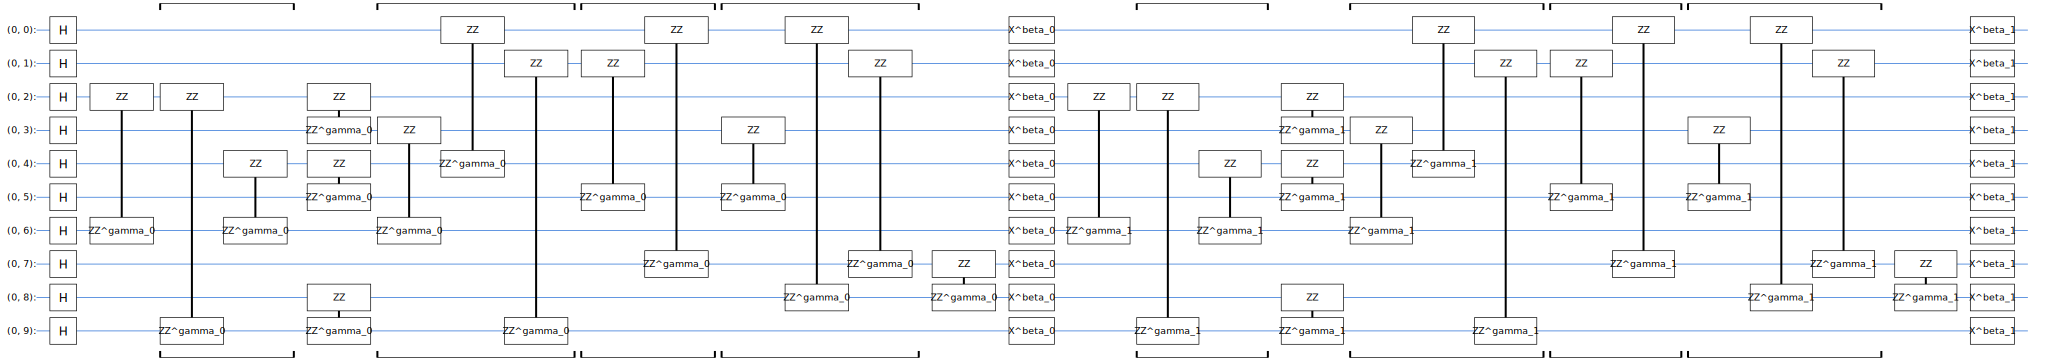

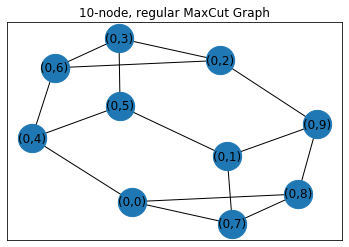

In [5]:
# Testing out the visualization function
graph_b = nx.random_regular_graph(n=10, d=3)
QAOA_circuit_vis(graph_b, 2)

## Function: create_graphs
Creates an arbitrary amount (graph_num) of a desired n-node udR MaxCut graph, can be used to create many models at once corresponding to these graph instances

1. Working through:
    - Uses maxcut_qaoa_TFQ_model function but is only limited to creating several instance of TFQ models for depth p=1, trying to generalize this for any depth p
    - Extension: once depth p can be varied, this functions could potentially return TFQ models for a specific n-node udR MaxCut graph instance SWEEPING p for a desired interval
        - This can easily provide the side by side differences in parameter optimization paths as p varies 

In [6]:
# Use qaoa_circuit, cost_op, hadamard_circuit for model

def create_graphs(node_num, deg_num, graph_num):
    dataset = []
    
    for i in range(graph_num):
        graph_rand = nx.random_regular_graph(n=node_num, d=deg_num)
        
        graph_rand_model_components = []
        model_components = maxcut_qaoa_TFQ_model(graph_rand, 1)
        graph_rand_model_components.append(model_components)
        dataset.append(graph_rand_model_components)

    return dataset

In [7]:
all_data = create_graphs(6, 3, 3)

# Model returns the tfq model for 3 different graph instances 
print("TFQ Model for graph 1:\n\n", all_data[0])
print("\nTFQ Model for graph 2:\n\n", all_data[1])
print("\nTFQ Model for graph 2:\n\n", all_data[2])

TFQ Model for graph 1:

 [(<tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffdc5d35150>, <tf.Tensor: id=105, shape=(1,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x9b\x04\x08\x01\x12\x96\x04\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_0\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_1\nW\n\x04\n\x02HP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x030_2\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x0

In [ ]:
# To have when portraying multiple plots

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title("main")
axs[1, 0].plot(x, y**2)
axs[1, 0].set_title("shares x with main")
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot(x + 1, y + 1)
axs[0, 1].set_title("unrelated")
axs[1, 1].plot(x + 2, y + 2)
axs[1, 1].set_title("also unrelated")
fig.tight_layout()